#Pip

In [1]:
!pip install -U torch
!pip install -U torchvision
!pip install -U fastai

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.1+cu101)
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.61)


#Import

In [2]:
%matplotlib inline

import os

import torch
from torch import nn, optim
from torchvision import transforms

import tensorflow as tf

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from collections import defaultdict, OrderedDict
import copy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import shutil

from google.colab import files

import fastai 
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

import albumentations as albu
from albumentations.pytorch import ToTensor

#Notebook Params

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device}')

SEED = 48

random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

cuda


#Data

##Directories

In [4]:
SOURCE_DIR = Path('/content/krasnodar_enmet')
CSV_FILE = SOURCE_DIR/'krasnodar_enmet_ann.csv'
IMAGES_DIR = SOURCE_DIR/'images/'
# To create
MASKS_DIR = SOURCE_DIR/'masks/'

##Load Data

In [5]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&code_challenge=eolGsXqj8B-IyVQRbEIxbQeHhyA_7HHbbdwiPs2CXMo&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: 4/1AEFNosrn8rEO7VxtOcoDtVUSVhQ2iER1Aox8fF_1m-Nb4jwWmDCzrM

You are now logged in as [zaplatinme@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


###gs://energy_meters_dataset/NEW_EM_DATASET_APRIL/krasnodar_enmet.zip

In [6]:
!gsutil cp gs://energy_meters_dataset/NEW_EM_DATASET_APRIL/krasnodar_enmet.zip /content/

Copying gs://energy_meters_dataset/NEW_EM_DATASET_APRIL/krasnodar_enmet.zip...
\ [1 files][  1.1 GiB/  1.1 GiB]   45.8 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


In [7]:
!unzip /content/krasnodar_enmet.zip

Archive:  /content/krasnodar_enmet.zip
   creating: krasnodar_enmet/
   creating: krasnodar_enmet/images/
  inflating: krasnodar_enmet/images/ (1).jpg  
  inflating: krasnodar_enmet/images/ (10).JPG  
  inflating: krasnodar_enmet/images/ (100).JPG  
  inflating: krasnodar_enmet/images/ (101).JPG  
  inflating: krasnodar_enmet/images/ (102).JPG  
  inflating: krasnodar_enmet/images/ (103).JPG  
  inflating: krasnodar_enmet/images/ (104).JPG  
  inflating: krasnodar_enmet/images/ (105).JPG  
  inflating: krasnodar_enmet/images/ (106).JPG  
  inflating: krasnodar_enmet/images/ (107).JPG  
  inflating: krasnodar_enmet/images/ (108).JPG  
  inflating: krasnodar_enmet/images/ (109).JPG  
  inflating: krasnodar_enmet/images/ (11).JPG  
  inflating: krasnodar_enmet/images/ (110).JPG  
  inflating: krasnodar_enmet/images/ (111).JPG  
  inflating: krasnodar_enmet/images/ (112).JPG  
  inflating: krasnodar_enmet/images/ (113).JPG  
  inflating: krasnodar_enmet/images/ (114).JPG  
  inflating: kra

In [8]:
!rm -rf /content/krasnodar_enmet.zip

In [9]:
df = pd.read_csv('/content/krasnodar_enmet/krasnodar_enmet_ann.csv', index_col=0)

In [10]:
df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,(1).jpg,1721260,"{""number"":""1207,94""}",2,0,"{""name"":""polygon"",""all_points_x"":[1207,2234,22...","{""type"":""number""}"
1,(1).jpg,1721260,"{""number"":""1207,94""}",2,1,"{""name"":""polygon"",""all_points_x"":[739,1950,195...","{""type"":""model""}"
2,(2).jpg,1620529,"{""number"":""487595"",""serial"":""№ 16817597 -13 г.""}",3,0,"{""name"":""polygon"",""all_points_x"":[995,1878,185...","{""type"":""number""}"
3,(2).jpg,1620529,"{""number"":""487595"",""serial"":""№ 16817597 -13 г.""}",3,1,"{""name"":""polygon"",""all_points_x"":[2014,2701,27...","{""type"":""serial""}"
4,(2).jpg,1620529,"{""number"":""487595"",""serial"":""№ 16817597 -13 г.""}",3,2,"{""name"":""polygon"",""all_points_x"":[751,1786,178...","{""type"":""model""}"


##Dataframe transforms

###Exclude model if needed

In [11]:
df = df[df['region_attributes'] != '{"type":"model"}']

###Exclude undefined

In [12]:
df = df[df['region_attributes'] != '{"type":undefined}']

##Make masks

###Create masks dir

In [13]:
!rm -rf /content/krasnodar_enmet/masks

In [14]:
!mkdir /content/krasnodar_enmet/masks

###Creating mask func

In [15]:
def get_mask(shape, df_items):
    mask = np.zeros(shape)
    
    palette = {
            'number': [255.0, 0.0, 0.0],
            'serial': [0.0, 255.0, 0.0]
        }

    for i in range(len(df_items)):
        pts = np.array(((eval(df_items['region_shape_attributes'].iloc[i])['all_points_x']),
                    (eval(df_items['region_shape_attributes'].iloc[i])['all_points_y'])))
        pts = np.moveaxis(pts, 0, -1)

        color = tuple(palette[eval(df_items['region_attributes'].iloc[i])['type']]) 
        cv2.fillPoly(mask, np.int32([pts]), color)

    return mask

###Creating masks
Delete 395.jpg

In [16]:
names = df['filename'].unique()

In [17]:
for f in tqdm(names):
    df_items = df.loc[df['filename'] == f]

    img = cv2.imread(str(IMAGES_DIR/f))
    mask = get_mask(img.shape, df_items)

    cv2.imwrite(str(MASKS_DIR/f), mask)

100%|██████████| 648/648 [04:39<00:00,  2.32it/s]


#DataBunch

##Dataset params

In [18]:
num_classes = 3
batch_size = 10
input_shape = (512, 512)
num_workers = 0
classes = ['background', 'number', 'serial']

##Transforms

##Create databunch

In [19]:
get_y_func = lambda x: MASKS_DIR/f'{x.stem}{x.suffix}'

In [20]:
data = (SegmentationItemList.from_folder(IMAGES_DIR)
        .split_by_rand_pct()       
        .label_from_func(get_y_func, classes=classes)
        .transform(size=512, tfm_y=True)
        .databunch(bs=batch_size))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

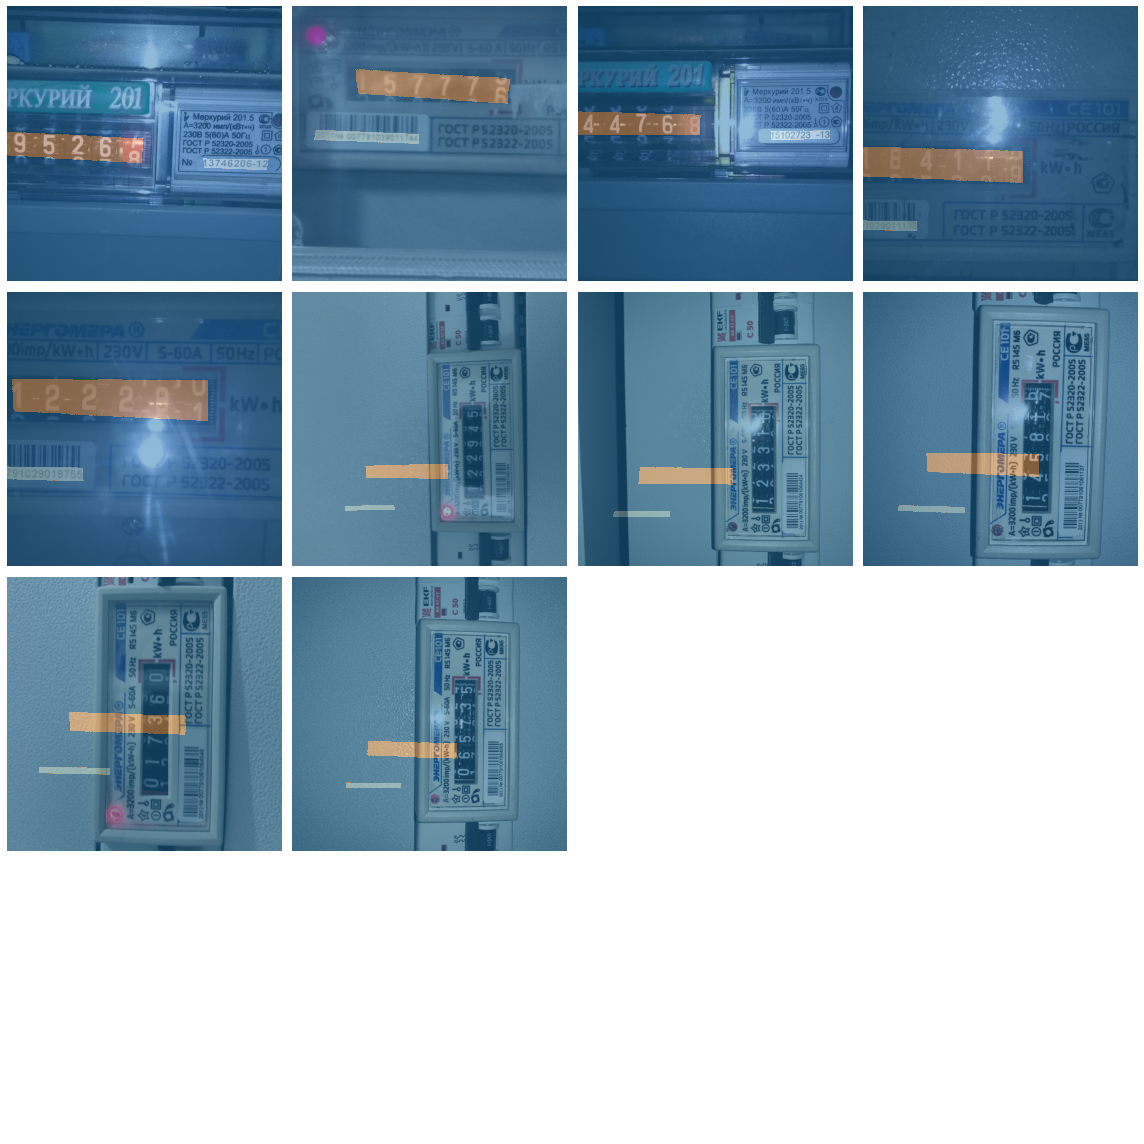

In [21]:
data.show_batch()

#Model

##Metrics

In [22]:
metrics = fastai.vision.dice

##Learner

In [23]:
learner = unet_learner(data, models.resnet34, metrics=metrics, wd=1e-4).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


#TensorBoard

In [ ]:
logdir = "/content/logs/segmentation"

%load_ext tensorboard
%tensorboard --logdir {logdir}

#Train

In [25]:
learner.fit_one_cycle(1, 3e-3)

RuntimeError: ignored

In [ ]:
pred = learner.predict(data.train_ds[2][0])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
img = data.train_ds[2][0]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


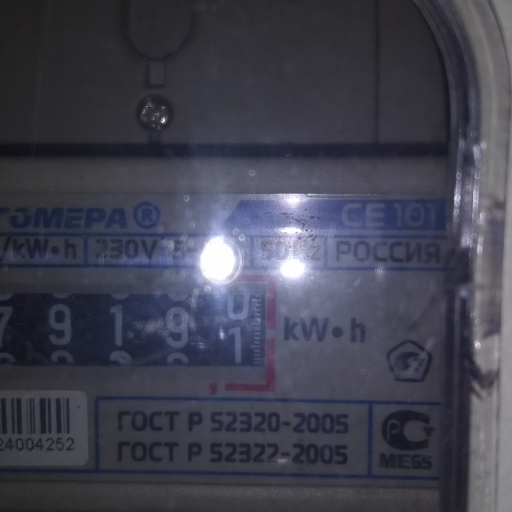

In [ ]:
img

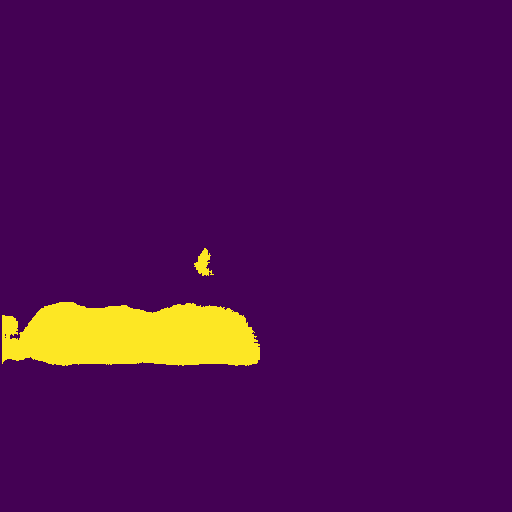

In [ ]:
pred[0]

#Save and download

In [ ]:
learner.save('/content/Unet_fastai_dice')

#Load model

In [ ]:
model.load_state_dict(torch.load('/content/Unet-ds-tr-bce.pth'))

#OHE to RGB

In [ ]:
def ohe_to_rgb(output: torch.Tensor) -> torch.Tensor:
        output = output.numpy()
        
        palette = {
            'number': [255.0, 0.0, 0.0],
            'serial': [0.0, 255.0, 0.0]
        }

        palette = [v for _, v in palette.items()]

        mask = np.zeros((512, 512, 3))
        for k in range(2):
            for i in range(512):
                for j in range(512):
                    if(output[k, i, j] > 0.90): mask[i, j, :] = palette[k]

        mask = torch.from_numpy(mask.transpose(2, 0, 1))  

        return mask 

#Test

In [ ]:
image = (cv2.cvtColor(cv2.imread('/content/0103461-1.jpg'), cv2.COLOR_BGR2RGB) / 255.).astype('float32')
image = cv2.resize(image, input_shape)

image = transform(image)

In [ ]:
model = model.to('cpu')
model.eval()

x = image.unsqueeze(0).float()

with torch.set_grad_enabled(False):
    outputs = model(x)

    outputs = torch.sigmoid(outputs)

    mask = ohe_to_rgb(outputs[0, :, :, :])

    plt.imshow(image.numpy().transpose(1, 2, 0) + mask.numpy().transpose(1, 2, 0))
    plt.show()

#Convert to torch mobile

In [ ]:
model = model.to('cpu')

In [ ]:
traced_script_module = torch.jit.trace(model, torch.rand(1, 3, input_shape[0], input_shape[1]))
traced_script_module.save("/content/Unet-tr-bce.pt")